In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
# === LOAD DATA ===
learning_path_data = pd.read_csv('data/simpleclass.csv')
user_data = pd.read_csv('data/userData.csv')

# Konversi graduated_course_ids ke list
user_data['graduated_course_ids'] = user_data['graduated_course_ids'].apply(
    lambda x: list(map(int, str(x).split(','))) if pd.notnull(x) else []
)

In [48]:
# === INPUT DATA USER ===
user_name = input("Masukkan nama pengguna: ").strip()
user_courses = user_data[user_data['user_name'] == user_name]

if user_courses.empty:
    print("Nama pengguna tidak ditemukan.")
else:
    # Course yang telah diselesaikan
    user_completed_courses = user_courses.iloc[0]['graduated_course_ids']
    completed_course_names = learning_path_data[
        learning_path_data['Course ID'].isin(user_completed_courses)
    ]['Course Name'].tolist()

    print(f"Course ID yang telah diselesaikan oleh {user_name}: {user_completed_courses}")
    print(f"Nama course yang telah diselesaikan oleh {user_name}: {completed_course_names}")


Masukkan nama pengguna:  Konik Saputra


Course ID yang telah diselesaikan oleh Konik Saputra: [14, 32, 51, 80, 86, 123, 145, 153, 159, 163]
Nama course yang telah diselesaikan oleh Konik Saputra: ['Memulai Pemrograman dengan Kotlin', 'Belajar Membuat Aplikasi Android untuk Pemula', 'Belajar Fundamental Aplikasi Android', 'Memulai Pemrograman dengan Python', 'Belajar Dasar Pemrograman Web', 'Belajar Fundamental Front-End Web Development', 'Memulai Pemrograman Dengan Swift', 'Memulai Pemrograman dengan Python', 'Belajar Membuat Aplikasi Flutter untuk Pemula', 'Belajar Dasar Pemrograman Web', 'Belajar Membangun LINE Chatbot', 'Belajar Membangun LINE Front-end Framework (LIFF)']



Progres Learning Path:
Android Developer: 1 / 1 courses completed
Back-End Developer JavaScript: 0 / 1 courses completed
Data Scientist: 0 / 1 courses completed
DevOps Engineer: 0 / 1 courses completed
Front-End Web Developer: 1 / 1 courses completed
Google Cloud Professional: 0 / 1 courses completed
Machine Learning Engineer: 0 / 1 courses completed
Multi-Platform App Developer: 0 / 1 courses completed
React Developer: 1 / 1 courses completed
iOS Developer: 1 / 1 courses completed


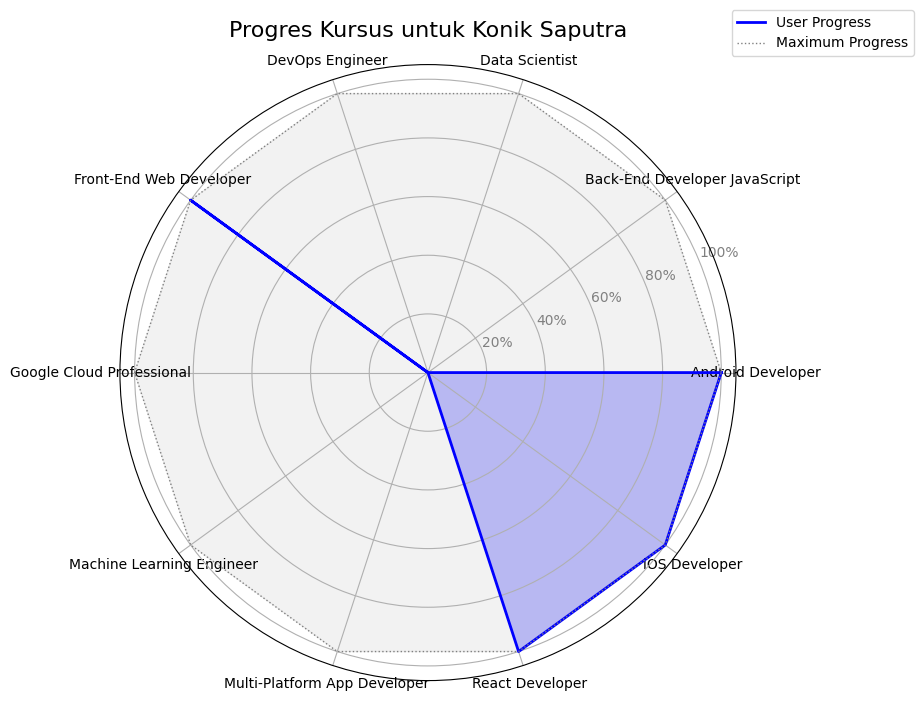

In [49]:
def display_course_progress_simple(user_name, learning_path_data, user_data):
    # Ambil data user
    user_courses = user_data[user_data['user_name'] == user_name]
    if user_courses.empty:
        print(f"Nama pengguna '{user_name}' tidak ditemukan.")
        return None, None, None

    # Pastikan ID kursus diselesaikan diubah ke tipe int
    graduated_course_ids = str(user_courses.iloc[0]['graduated_course_ids'])
    user_completed_courses = set(
        int(x.strip().strip("[]")) for x in graduated_course_ids.split(",")
    )

    # Hitung course yang diselesaikan per learning path
    learning_path_data['Completed'] = learning_path_data['Course ID'].apply(
        lambda x: 1 if x in user_completed_courses else 0
    )
    completions = learning_path_data.groupby('Learning Path')['Completed'].sum()
    totals = learning_path_data.groupby('Learning Path')['Course ID'].count()

    # Tampilkan progres semua learning path
    print("\nProgres Learning Path:")
    for lp in completions.index:
        print(f"{lp}: {completions[lp]} / {totals[lp]} courses completed")
    
    return completions.index.tolist(), completions.tolist(), totals.tolist()

# Panggil fungsi
labels, completions, totals = display_course_progress_simple(user_name, learning_path_data, user_data)

# Buat spider diagram
if labels:
    # Hitung persentase
    values = [c / t for c, t in zip(completions, totals)]
    max_values = [1] * len(labels)

    # Tambahkan nilai pertama untuk menutup diagram
    values += values[:1]
    max_values += max_values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist() + [0]

    # Plot spider diagram
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2, label='User Progress')
    ax.fill(angles, max_values, color='grey', alpha=0.1)
    ax.plot(angles, max_values, color='grey', linewidth=1, linestyle='dotted', label='Maximum Progress')

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], color='grey', fontsize=10)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(f'Progres Kursus untuk {user_name}', size=16, pad=20)
    plt.show()


In [36]:
# === REKOMENDASI COURSE ===
# Membuat matriks user-course
all_courses = sorted(set(learning_path_data['Course ID']))
user_course_matrix = pd.DataFrame(0, index=user_data['user_name'], columns=all_courses)

for i, row in user_data.iterrows():
    for course_id in row['graduated_course_ids']:
        user_course_matrix.at[row['user_name'], course_id] = 1

# Similarity matrix antar pengguna
similarity_matrix = cosine_similarity(user_course_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=user_data['user_name'], columns=user_data['user_name'])

def recommend_courses_with_names(user_name, top_n=3):
    if user_name not in similarity_df.index:
        return []

    similar_users = similarity_df[user_name].sort_values(ascending=False).iloc[1:top_n+1].index
    recommended_courses = set()

    for similar_user in similar_users:
        similar_user_courses = set(user_data[user_data['user_name'] == similar_user].iloc[0]['graduated_course_ids'])
        user_courses = set(user_data[user_data['user_name'] == user_name].iloc[0]['graduated_course_ids'])
        recommended_courses.update(similar_user_courses - user_courses)

    course_names = learning_path_data.set_index('Course ID').loc[list(recommended_courses), 'Course Name'].tolist()
    return course_names

recommended_names = recommend_courses_with_names(user_name)
print(f"Rekomendasi courses untuk {user_name}: {recommended_names}")

Rekomendasi courses untuk Hamam Nasrodin: ['Memulai Pemrograman dengan Kotlin', 'Memulai Pemrograman dengan Dart', 'Belajar Dasar Visualisasi Data', 'Belajar Membuat Aplikasi Android untuk Pemula', 'Belajar Membuat Aplikasi Flutter untuk Pemula']
